## Importing Necessary Packages

In [1]:
##packages we need for image processing

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from pandas import get_dummies


##packages that could be used for improved model performance
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from scipy.stats import uniform

## Loading and Processing Data

**First we will define the functions we need to load and preprocess data**

In [85]:
# define a function to load the data from a train and test folder
def load_data(data_path):
    
    counter = 0
    x = []
    y = []

    ##identify total files
    n = 0 ##initialize count

    ##loop through all folder in data_path and count file number then add to total count
    ##This is done so we can count the percent complete
    for folder in os.listdir(data_path):
        n += len(os.listdir(os.path.join(data_path, folder))) ##add current count to toal

    ##Load all files into x and y
    for folder in os.listdir(data_path):
        label = folder ##define a label for outcome (pneumonia vs normal) based on folder name

        ##loop through all files and load as array with opencv 
        ##We will convert to greyscale for comp efficiency and resize to a 150 by 150 image for conv filter
        ##converting to greyscale for an Xray image should not lose too much information
        ##150 is arbitrary, but standard practice in image analysis since it 
        ##reduces size, standardizes size of images, and helps extract ore meaningful feature
        
        for file in os.listdir(os.path.join(data_path, folder)):
            img_path = os.path.join(data_path, folder, file)
            img = cv2.imread(img_path) ##read image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) ##convert to greyscale
            img = cv2.resize(img, (150, 150))##resize
            x.append(img) ##add image array to x
            y.append(label) ##add label to y
            
            ##calculate percent complete
            counter += 1 ##total loaded
            print(f"Percent Complete: {np.round(100*counter/n, 0)}%", end = "\r")
            
    ##convert list of image arrays to an array 
    x = np.array(x) ##(nsample, 150, 150)
    y = np.array(y) ##(nsample,)

    return x, y



# define a function to preprocess the data for the CNN Model
# Note that we are NOT going to augment data, but it could be done to reduce ovefitting
def preprocess_data(data_path, validation_prop=0.15):
    
    ##specify training and test paths within data_path since already created
    train_path = os.path.join(data_path, 'train')
    test_path = os.path.join(data_path, 'test')
    
    ##load all data
    print("Loading Train Data")
    x_train, y_train = load_data(train_path)
    print("Loading Test Data")
    x_test, y_test = load_data(test_path)
    
    ##process x_train data
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 
                              x_train.shape[2], 1) ##shape: (N_sample, 150, 150, 1) adds a channel dimension
    x_train = x_train.astype('float32') ##coerce to float type
    x_train /= 255 ##normalize x so that all values are between 0 and 255 (RGB scale)
    
    ##process x_test data
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 
                              x_test.shape[2], 1) ##shape: (N_sample, 150, 150, 1) adds a channel dimension
    x_test = x_test.astype('float32') ##coerce to float type
    x_test /= 255 ##normalize x so that all values are between 0 and 255 (RGB scale)
    
    ##process y data (output will be one vector with 1 for Pneumonia and 0 for Normal cases)
    y_train = get_dummies(y_train)['PNEUMONIA'].to_numpy() ##converts train to factor 
    y_test = get_dummies(y_test)['PNEUMONIA'].to_numpy() ##converts test to factor 
    

    
    ##create a validation set from the training set that can be used to optimize the model
    ##the original test set will ONLY be used to assess how well the tuned and trained model performs
    x_train_new, x_val, y_train_new, y_val = train_test_split(x_train, y_train, 
                                                              test_size = validation_prop, random_state = 42)
    

    return x_train_new, x_test, x_val, y_train_new, y_test, y_val


**Now we will actually load in the data**

In [86]:
##specify paths
data_path = 'C:/Users/Jonathan/Documents/Tutoring/CJ_C/Session_1/dataset/'

##load and preprocess data
x_train, x_test, x_val, y_train, y_test, y_val = preprocess_data(data_path)

Loading Train Data
Loading Test Data 100.0%


**We can visualize some random images from the loaded dataset to understand what we are processing**

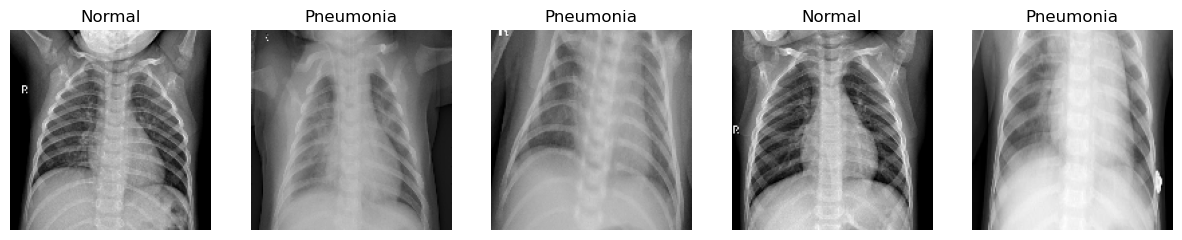

In [95]:
# generate random indices to select 5 images from x_train
np.random.seed(25)
random_indices = np.random.choice(x_train.shape[0], size=5, replace=False)

# create a subplot with 1 row and 5 columns
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

# loop through the the first 5 selected images
for i, idx in enumerate(random_indices):
    # show the image on the current axis using imshow
    ax[i].imshow(x_train[idx], cmap = "gray")
    ax[i].axis('off') # remove axis labels
    label = "Pneumonia" if y_train[idx] == 1 else "Normal"
    ax[i].set_title(label)

# display the plot
plt.show()

## Build, Compile, and Train CNN Model

**Now we will define the functions that will build, compile, and train our model**

Note that I do not do any tuning except for the learning rate optimizer since this is just the framework for a model. Additionally, I do not augment the data (transform, flip, shift, etc.). Things that could be tuned are number of layers, number of filters in each layer, dropout rate, epochs, batch size, etc.

In [88]:
# define a function to build the CNN model
def build_model(dropout_rate = 0.2):
    model = Sequential() # create an empty model

    # add convolutional and max pooling layers
    
    # input shape is (150, 150, 1) since our x_train data 
    # has 150 x 150 x 1 dimensions per sample (height, width, channel)
    ##all activation functions are ReLU which introduces non-linearity to handle non-linear data
    ##ReLU sets negative values to 0 and positive values keeps the same
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1))) ##32 filters (basic like edges)
    model.add(MaxPooling2D((2, 2))) 
    model.add(Conv2D(64, (3, 3), activation='relu')) ##64 filters (more complex)
    model.add(MaxPooling2D((2, 2))) 
    model.add(Conv2D(128, (3, 3), activation='relu')) ## 128 filters (much more complex)
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu')) ## 128 filters (high level features)
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu')) ## 128 filters (high level features)
    model.add(MaxPooling2D((2, 2)))

    # add dropout layer to reduce potential overfitting
    # Randomly drops a number of output units (20% by default) to prevent reliance on
    # specific features which makes it more robust
    model.add(Dropout(dropout_rate, seed = 32)) ##set seed for reproducibility

    model.add(Flatten()) # flatten the output of the convolutional layers (to enable input into a fully connected layer)
    
    # add fully connected layers
    
    # The Dense layer is a fully connected layer that takes the output of the convolutional layers as input
    # The ReLU activation function performs a weighted sum of the inputs from the previous layer, followed by non-linearity
    # Negative values become 0 and positive values stay the same, 
    # reducing computational cost and selecting important features
    # The number of neurons in this layer (512) is arbitrarily chosen and needs to be tuned
    # The number of neurons in this layer affects the model's capacity to learn complex features
    model.add(Dense(512, activation='relu')) ##relu layer
    
    # The output layer uses the sigmoid activation function to output a single probability value between 0 and 1
    # This value can be used to classify an input image as belonging to one of two classes (0 or 1)
    # The number of neurons in this layer is 1, since our output is one-dimensional (binary classification)
    model.add(Dense(1, activation='sigmoid')) # output layer with sigmoid activation (1 means y is 1 dimensional)
    
    return model # return the built model
   

# define a function to compile and train the CNN model
def compile_train_model(x_train, y_train, x_val, y_val,
                        lr=0.001, metrics=['accuracy'], epochs=20, batch=32,
                        patience=3, factor=0.1):
    
    model = build_model() # build the CNN model with default dropout_rate of 0.2

    # compile the model with binary_crossentropy loss function,
    # Adam optimizer with a specified learning rate (default 0.01),
    # and specified evaluation metrics (default is accuracy)
    Adam = tf.keras.optimizers.Adam # load optimizer
    optimizer = Adam(learning_rate=lr)  # define the optimizer with the specified learning rate

    # compile the model with binary_crossentropy loss function and the defined optimizer
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)
    
    ##print out summary of model
    print(model.summary())
    print("\n")

    # define the ReduceLROnPlateau callback to reduce the learning rate if validation loss has not improved
    # patience is how many epochs to wait while monitoring improvement (default 3)
    # factor is the factor that learning rate will be reduced (default 0.01)
    # verbose = 1 specifies that a message will be printed each time lr is decreased
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
    
    # train the model on the training data with the specified number of epochs,
    # batch size (default 32), and validation data for monitoring performance
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch, 
                        validation_data=(x_val, y_val), callbacks=[lr_scheduler])

    # return the trained model and its history
    return model, history





**Now we will actually build, compile, and train the model*

In [89]:
##compile and train model
##the patience and factor variables allow for learning rate scheduler to update 
##the learning rate every 3 epochs by a factor of 0.1 if the validation loss does not decrease
epochs = 10
model, history = compile_train_model(x_train=x_train, y_train=y_train,
                                     x_val=x_val, y_val=y_val, epochs=epochs,
                                     lr = 0.001, patience = 3, factor = 0.1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 17, 17, 128)    

## Evaluate Model

In [90]:
# define a function to evaluate the trained CNN model
def evaluate_model(model, history, x_test, y_test):
    
    # plot accuracy vs epoch for both training accuracy and validation accuracy
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    
    # Predict labels for test data (output ranges 0 to 1, so above threshold 0.5 is 1 and less than/equal is 0)
    y_pred = model.predict(x_test) > 0.5
    
    # Compute and print confusion matrix
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n")
    
    # Compute and print true negative, false positive, false negative, and true positive
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f'True Negative: {tn}')
    print(f'False Positive: {fp}')
    print(f'False Negative: {fn}')
    print(f'True Positive: {tp}')
    print("\n")
    
    # evaluate accuracy on true test data (unseen data)
    test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
    
    # Compute recall, precision, and F1 score
    recall = recall_score(y_test, y_pred) ##TP/(TP + FN): True positive rate
    precision = precision_score(y_test, y_pred)  ##TP/(TP+FP): Correct positive prediction rate
    specificity = tn/(tn + fp) ##true negative rate
    f1 = f1_score(y_test, y_pred)
    
    # Print true loss, accuracy, recall, precision, specificity, and F1

    print(f"True Test Loss (Binary Cross Entropy): {test_loss}")
    print(f"True Test Accuracy (Binary Cross Entropy): {test_acc}")
    print("\n")
    
    print(f'Recall/Sensitivity: {recall}')
    print(f'Precision: {precision}')
    print(f'Specificity: {specificity}')
    print(f'F1 Score: {f1}')
    
    return test_loss, test_acc, recall, precision, specificity, f1, conf_matrix


**Now we will actually evaluate the model**

20/20 [==============================] - 1s 68ms/step
Confusion Matrix:
[[126 108]
 [  4 386]]


True Negative: 126
False Positive: 108
False Negative: 4
True Positive: 386


20/20 - 1s - loss: 0.8099 - accuracy: 0.8205 - 1s/epoch - 67ms/step
True Test Loss (Binary Cross Entropy): 0.8099271059036255
True Test Accuracy (Binary Cross Entropy): 0.8205128312110901


Recall/Sensitivity: 0.9897435897435898
Precision: 0.7813765182186235
Specificity: 0.5384615384615384
F1 Score: 0.8733031674208146


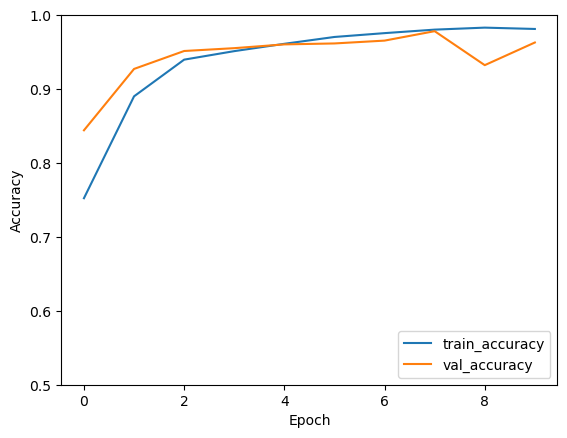

In [91]:
##evaluate model performance on validation and true test data
test_loss, test_acc, recall, precision, specificity, f1, conf_matrix = evaluate_model(model, history, x_test, y_test)

We note that the data has a low specificity (seems to falsely predict positive cases often), which may be a function of imbalanced data. To improve this, you could specifically augment (transpose, flip, etc) just the negative case (normals)

In [92]:
pos_train_perc = 100 * np.round(np.sum(y_train)/len(y_train), 3)
print(f'Percantage Positive Cases in Training Data: {pos_train_perc}%')


Percantage Positive Cases in Training Data: 74.5%


**Sample Conclusions:**

High Recall (99.0%) indicates that if it is predicted negative, it is almost always going to be truly negative.
Precision of 78% says that 22% of the time a positive prediction will be wrong (false positive)
Low Specificity is a function of the fact that 22% of all positive predictions are falsely positive

